In [1]:
!git clone https://github.com/muxspace/facial_expressions.git

fatal: destination path 'facial_expressions' already exists and is not an empty directory.


In [2]:
%cd /Users/helenfeng/Programming/BSE/

/Users/helenfeng/Programming/BSE


In [3]:
%matplotlib inline
from pylab import *
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os
from collections import Counter
import time
import PIL
import pickle
import cv2

In [4]:
def saveData(src, pklname, csv_path, width=350, height=None):
    # assuming you have the current file structure:
    # ./
    #   data/
    #   images/
    height = height if height is not None else width

    data = dict() # our data structure
    data['desc'] = 'resized ({0}x{1}) face images in rgb'.format(width, height)
    data['label'] = []
    data['filename'] = []
    data['image'] = []

    pklname = f"{pklname}_{width}x{height}px.pkl" # filename for pickle file: 'emotions_350x350px.pkl', fun fact: this is standard practice for saving data in ML!
    
    if os.path.exists(pklname):
        os.remove(pklname)
        
    csv_data = pd.read_csv(csv_path) # create dataframe to match labels and images        
    
    for i in range(len(csv_data)):
        csv_data.iloc[i]['emotion'] = csv_data.iloc[i]['emotion'].lower()

    # get images from dir
    for subdir in os.listdir(src): # src should be '.'
        if subdir == 'images': # grabs images/
            curr_path = os.path.join(src, subdir) # combines ./ and images/ --> ./images/ 
            for file in tqdm(os.listdir(curr_path)): # iterates through files in ./images/
    #         if file[-3:] in {'jpg', 'png'}: 
                try:
                    im = imread(os.path.join(curr_path, file))
                    im = resize(im, (width, height))
                    c = np.expand_dims(im, axis=-1)
        
                    if c.shape[2] != 1:
                        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
                    index = csv_data.index[csv_data['image']==file][0] # get index of the file we are looking at in the csv file
                    data['label'].append(csv_data.iloc[index]['emotion']) # uses iloc (operated by index) to get element (emotion in str form)
                    
                    data['filename'].append(file) # image name
                    data['image'].append(im) # image data
                    
                except Exception:
                    continue       
            break
            

    f = open(pklname, "wb")
    pickle.dump(data, open(pklname,"wb")) # pickle.dump creates a pickle file with our data structure and dumps it into the pickle file with pklname
    print('done')
    f.close()
    return

In [ ]:
pklname = 'emotions'
width = 350
include = 'data/legend.csv'

saveData(os.curdir, pklname, csv_path=include, width=width)

In [5]:
from collections import Counter

with open('emotions_350x350px.pkl', 'rb') as f:
    data = pickle.load(f)
    f.close()

In [6]:
print('number of samples: ', len(data['image']))
print('keys: ', list(data.keys()))
print('description: ', data['desc'])
print('image shape: ', data['image'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  12758
keys:  ['desc', 'label', 'filename', 'image']
description:  resized (350x350) face images in rgb
image shape:  (350, 350)
labels: ['anger' 'contempt' 'disgust' 'fear' 'happiness' 'neutral' 'sadness'
 'surprise']


Counter({'neutral': 6713,
         'happiness': 5306,
         'surprise': 355,
         'sadness': 124,
         'anger': 227,
         'disgust': 12,
         'fear': 12,
         'contempt': 9})

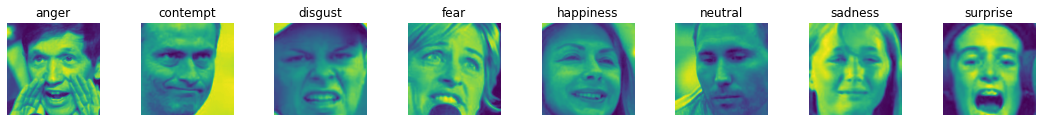

In [7]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['image'][idx])
    ax.axis('off')
    ax.set_title(label)

# Start organizing data into train/test sets

In [8]:
images = []
for img in data['image']:
  images.append(img.ravel())

In [9]:
images[0].shape

(122500,)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    images, 
    data['label'], 
    test_size=0.2, 
    shuffle=True,
    random_state=21
)

In [11]:
X_train[0].shape

(122500,)

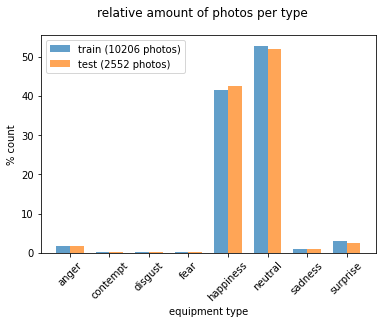

In [12]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

# processing

hog stands for histogram oriented gradients and is used for feature extraction

Create the [SGD Classifier (stochastic gradient descent)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.fit)

- fits a linear SVM by default
- helps us complete the HOG and SVM process for image detection

In [13]:
from sklearn.svm import SVC
svc_1 = SVC(kernel='linear')

In [14]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y):
    # create a k-fold cross validation iterator
    cv = KFold(n_splits=len(y), random_state=5, shuffle=True)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: {0:.3f} (+/-{1:.3f})".format(
        np.mean(scores), sem(scores)))

In [15]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print ("Accuracy on training set:")
    print (clf.score(X_train, y_train))
    print ("Accuracy on testing set:")
    print (clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print ("Classification Report:")
    print (metrics.classification_report(y_test, y_pred))
    print ("Confusion Matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))

In [ ]:
train_and_evaluate(svc_1, X_train, X_test, y_train, y_test)
